In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hd_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac_csvs"
brain_region = '#15616F'

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n7-240821-114717/Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n2-240507-093913/Notes.txt
read from t=0s to t=1511.09s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n6-240821-100116/Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n1-240507-080133/Notes.txt
read from t=0s to t=1573.39s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n3-240507-115440/Notes.txt
read from t=0s to t=1494.38s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n5-240821-085040/Notes.txt
read from t=0s to t=1324.06s
Found Synapse note file: /Users/naylajim

In [4]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for n7-240821-114717...
Processing behaviors for n2-240507-093913...
Processing behaviors for n6-240821-100116...
Processing behaviors for n1-240507-080133...
Processing behaviors for n3-240507-115440...
Processing behaviors for n5-240821-085040...
Processing behaviors for n4-240507-140651...


Total Investigation Time

In [ ]:
filtered_summary_df = automate_investigation_workflow(
    experiment=experiment,
    trial_keys=["n1-240507-080133", "n2-240507-093913", "n3-240507-115440", 
                "n4-240507-140651", "n5-240821-085040", "n6-240821-100116", "n7-240821-114717"],
    combine_threshold=1,
    min_duration=2,
    desired_bouts=["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"],
    exclude_subjects=[5],
    calc_method="average"
)

print(filtered_summary_df.head())

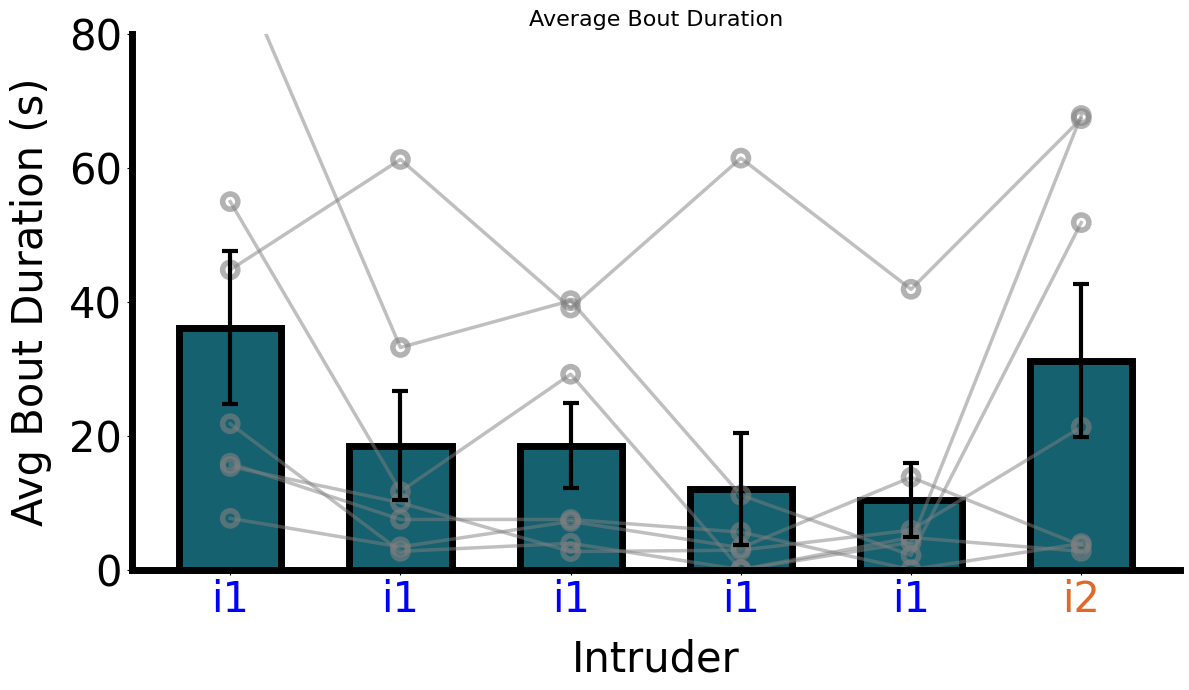

In [19]:
# Pivot the DataFrame so that each row is a subject and each column is a bout,
# and the values are numeric (average bout duration)
grouped_df = filtered_summary_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Ensure no missing numeric values

plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Bout Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 80),
    bar_color=brain_region,  # make sure brain_region is defined, e.g., brain_region = "#00B7D7"
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

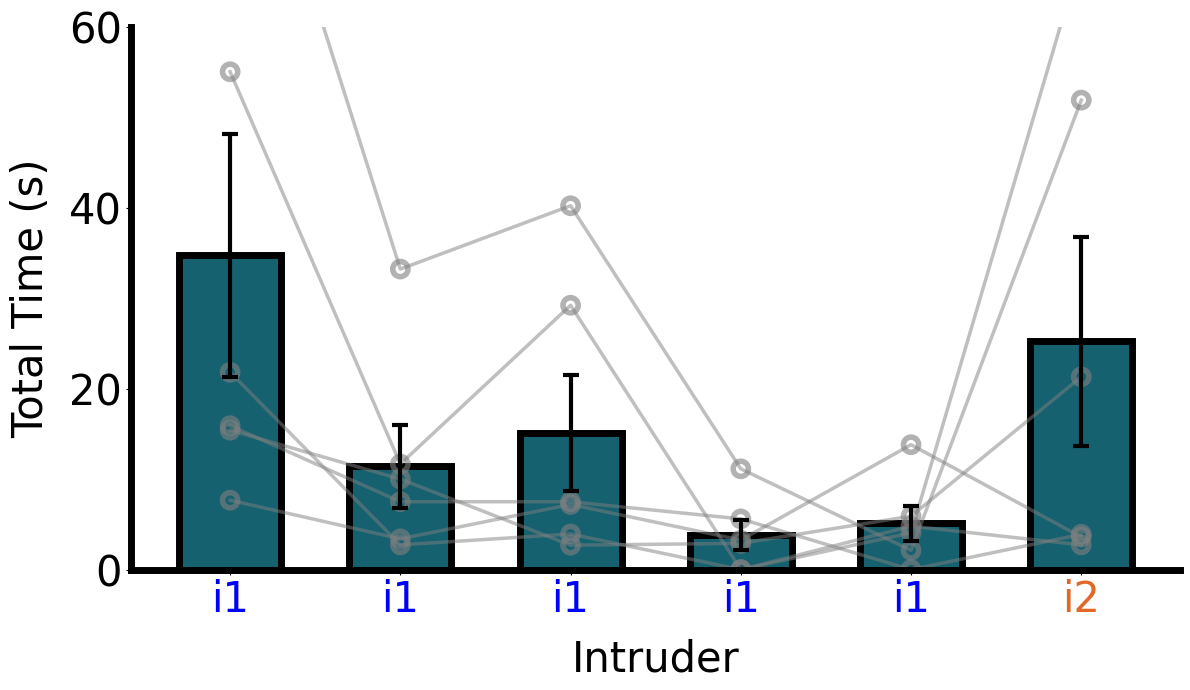

In [20]:
nn1 = experiment.trials['n1-240507-080133']
nn2 = experiment.trials['n2-240507-093913']
nn3 = experiment.trials['n3-240507-115440']
nn4 = experiment.trials['n4-240507-140651']
nn5 = experiment.trials['n5-240821-085040']
nn6 = experiment.trials['n6-240821-100116']
nn7 = experiment.trials['n7-240821-114717']

for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=2)

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)
# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)
    
# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]
# Remove Subject 5 from the filtered summary DataFrame
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Group by Subject and Bout and sum Duration (s) to ensure unique pairs
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()

# Pivot the grouped DataFrame so that rows are subjects and columns are bouts
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Then call your plotting function
plot_y_across_bouts_gray(
    df=pivot_df,
    title=None,
    ylabel="Total Time (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 60),
    bar_color=brain_region,
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

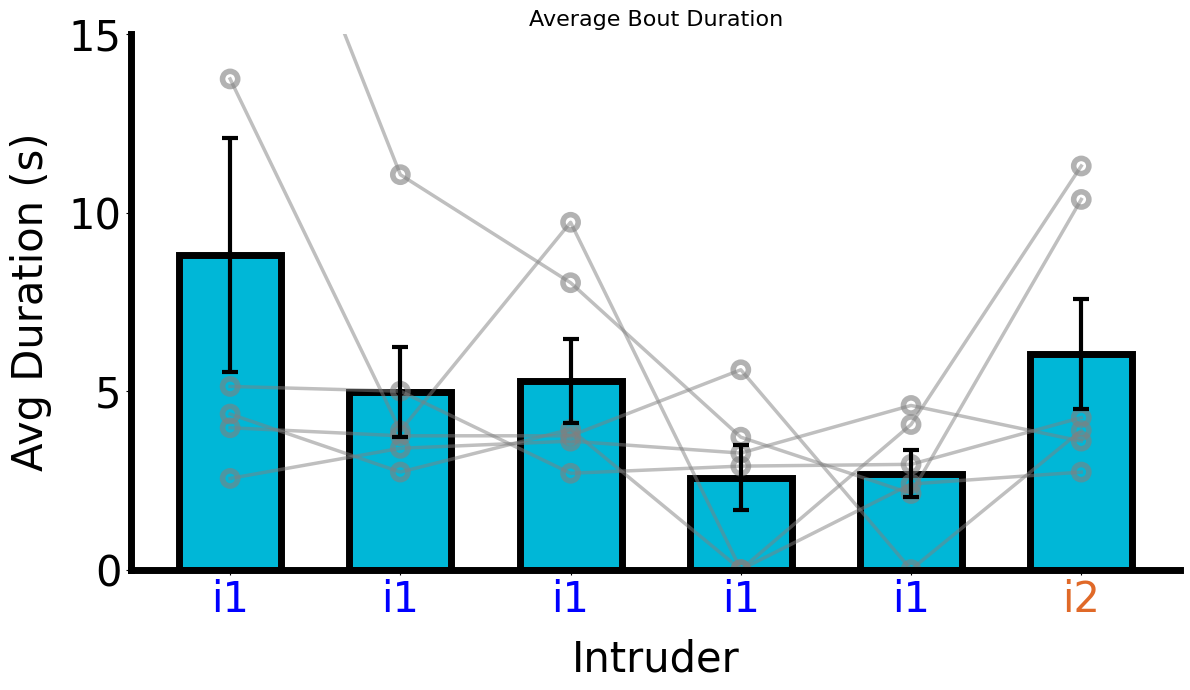

In [21]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# 4) Plot using the "Average Bout Duration" label
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

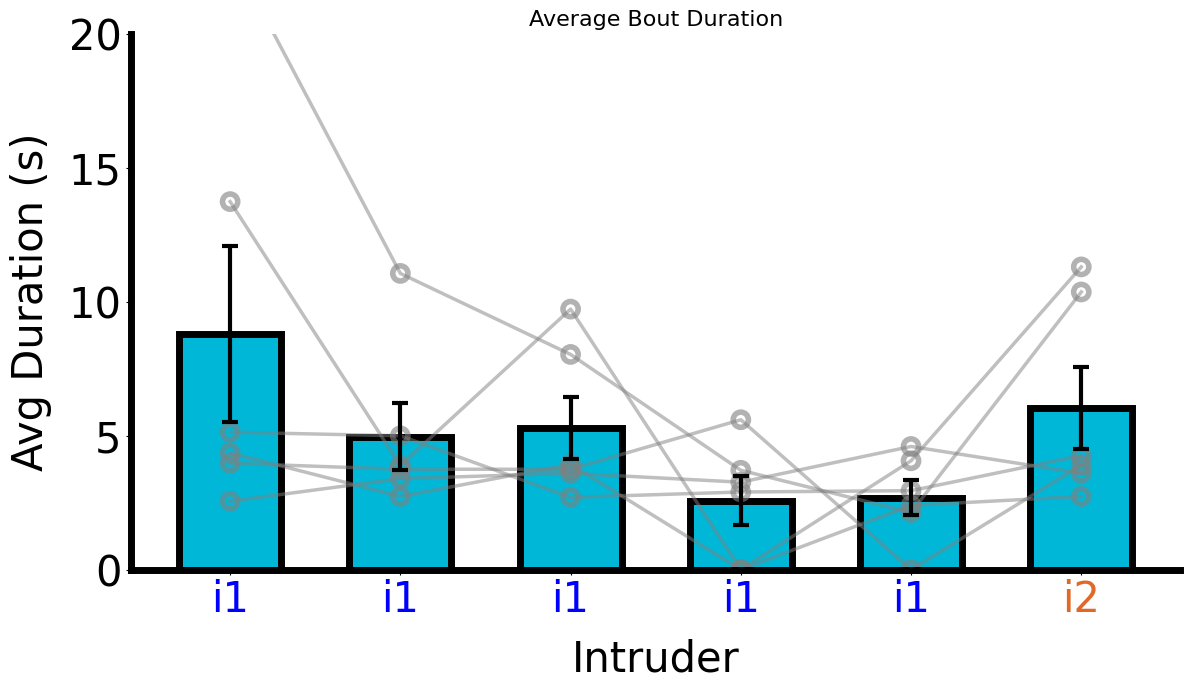

In [22]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# --- Plot the Total Investigation Time Across Bouts for the Filtered Bouts ---
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 20),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

In [23]:
nn1 = experiment.trials['n1-240507-080133']
nn2 = experiment.trials['n2-240507-093913']
nn3 = experiment.trials['n3-240507-115440']
nn4 = experiment.trials['n4-240507-140651']
nn5 = experiment.trials['n5-240821-085040']
nn6 = experiment.trials['n6-240821-100116']
nn7 = experiment.trials['n7-240821-114717']

for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=2)

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)
# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)



# --- Combine Processed Behaviors into a Summary DataFrame ---
trials = [
    nn1.behaviors, nn2.behaviors, nn3.behaviors,
    nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors
]


summary_df = create_subject_summary_df(trials)

# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# 1) Remove Subject 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]






In [24]:
# 1) Process each subject's DataFrame (nn1.behaviors, nn2.behaviors, etc.)
processed_dfs = []
for df in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events within a 5-second threshold
    merged_df = Trial.combine_consecutive_behaviors(
        df, behavior_name='Investigation', bout_time_threshold=5
    )
    # Remove Investigation events shorter than 1 second
    short_removed_df = Trial.remove_short_behaviors(
        merged_df, behavior_name='Investigation', min_duration=1
    )
    processed_dfs.append(short_removed_df)

# 2) Combine the processed DataFrames into a single summary DataFrame
summary_df = create_subject_summary_df(processed_dfs)

# 3) Remove Subject 5 from the summary (i.e., rows where Subject == 5)
summary_df = summary_df[summary_df["Subject"] != 5]

# 4) Filter the summary DataFrame to include only the desired bouts
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# 5) Plot the total Investigation Time across bouts, y-axis from 0 to 75
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # or "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects, No Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)

AttributeError: 'NoneType' object has no attribute 'behaviors'

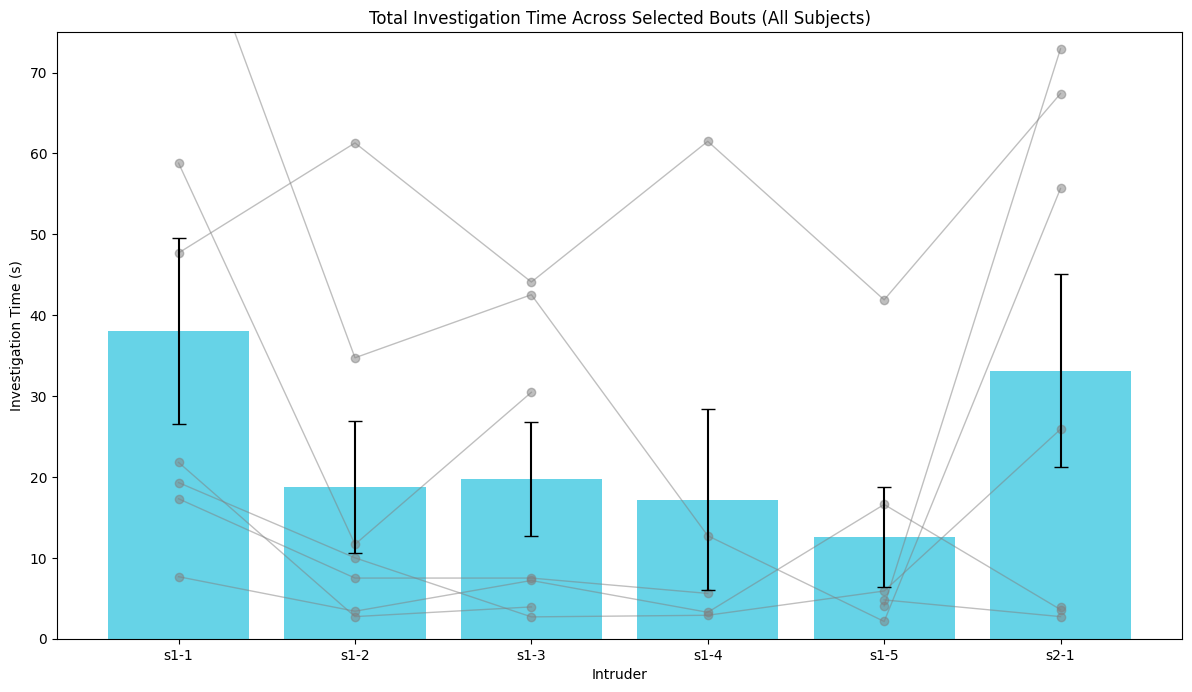

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Standalone Functions for Behavior Processing
# --------------------------
def combine_consecutive_behaviors(df, behavior_name='all', bout_time_threshold=1):
    """
    Combines consecutive behavior events if they occur within the specified time threshold.
    
    Parameters:
      df (DataFrame): Input DataFrame with columns ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)'].
      behavior_name (str): If not 'all', only process rows matching this behavior.
      bout_time_threshold (float): Maximum gap (in seconds) allowed between consecutive events to merge them.
      
    Returns:
      DataFrame with merged events.
    """
    if df.empty:
        return df.copy()
    
    # If processing only a specific behavior, work on that subset
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    # Sort by Bout, Behavior, and Event_Start to ensure proper merging
    working_df = working_df.sort_values(by=['Bout', 'Behavior', 'Event_Start']).reset_index(drop=True)
    
    combined_rows = []
    # Group by Bout and Behavior to merge events in each group
    for (bout, behavior), group in working_df.groupby(['Bout', 'Behavior']):
        group = group.sort_values('Event_Start').reset_index(drop=True)
        current_start = group.loc[0, 'Event_Start']
        current_end = group.loc[0, 'Event_End']
        
        for i in range(1, len(group)):
            next_start = group.loc[i, 'Event_Start']
            next_end = group.loc[i, 'Event_End']
            
            # If the gap between events is within threshold, merge them
            if next_start - current_end <= bout_time_threshold:
                current_end = next_end  # extend the current event
            else:
                combined_rows.append({
                    'Bout': bout,
                    'Behavior': behavior,
                    'Event_Start': current_start,
                    'Event_End': current_end,
                    'Duration (s)': current_end - current_start
                })
                # Reset to the next event
                current_start = next_start
                current_end = next_end
        
        # Append the last merged event in the group
        combined_rows.append({
            'Bout': bout,
            'Behavior': behavior,
            'Event_Start': current_start,
            'Event_End': current_end,
            'Duration (s)': current_end - current_start
        })
    
    return pd.DataFrame(combined_rows)


def remove_short_behaviors(df, behavior_name='all', min_duration=0):
    """
    Removes events with duration less than min_duration.
    
    Parameters:
      df (DataFrame): Input DataFrame with a 'Duration (s)' column.
      behavior_name (str): If not 'all', only process rows matching this behavior.
      min_duration (float): Minimum duration (in seconds) required to keep an event.
      
    Returns:
      Filtered DataFrame.
    """
    if df.empty:
        return df.copy()
    
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    working_df = working_df[working_df['Duration (s)'] >= min_duration]
    return working_df.reset_index(drop=True)

# --------------------------
# Functions for Creating Summary & Plotting
# --------------------------
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each representing one subject's processed behaviors),
    assigns a unique Subject ID (1 to N) to each DataFrame, and computes:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        temp_df["Subject"] = subject_id
        
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1
    
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


def hab_dishab_plot_y_across_bouts_gray(df, 
                                        title='Mean Across Bouts', 
                                        ylabel='Mean Value', 
                                        custom_xtick_labels=None, 
                                        custom_xtick_colors=None, 
                                        ylim=None, 
                                        bar_color='#00B7D7',
                                        yticks_increment=None, 
                                        xlabel='Intruder',
                                        figsize=(12,7), 
                                        pad_inches=1):
    """
    Plots the mean values (with SEM error bars) for each bout, and overlays each subject's data in gray.
    
    Parameters:
      df (DataFrame): rows = subjects, columns = bouts, values = metric to plot.
      title, ylabel, etc.: standard plotting options.
    """
    fig, ax = plt.subplots(figsize=figsize)
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))
    
    # Plot each subject's data in gray
    for idx in df.index:
        ax.plot(x, df.loc[idx, :], color='gray', alpha=0.5, marker='o', linewidth=1)
    
    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)
    
    # Configure x-tick labels and colors if provided
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))
    
    plt.tight_layout(pad=pad_inches)
    plt.show()


def plot_behavior_metric(df, 
                         behavior="Investigation", 
                         metric="investigation_time",
                         title='Mean Across Bouts',
                         ylabel='Mean Value',
                         ylim=None):
    """
    Filters the summary DataFrame by a given Behavior, then computes:
      - 'investigation_time': sum of "Duration (s)" per Subject & Bout
      - 'average_bout_duration': mean of "Duration (s)" per Subject & Bout
    Pivots to a subject-by-bout DataFrame and plots with hab_dishab_plot_y_across_bouts_gray.
    """
    filtered_df = df[df["Behavior"] == behavior].copy()
    
    if metric == "investigation_time":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
        plot_label = "Investigation Time (Sum)"
    elif metric == "average_bout_duration":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
        plot_label = "Average Bout Duration (Mean)"
    else:
        raise ValueError("metric must be either 'investigation_time' or 'average_bout_duration'")
    
    pivot_df = grouped.pivot(index="Subject", columns="Bout", values="Duration (s)")
    hab_dishab_plot_y_across_bouts_gray(
        df=pivot_df,
        title=title,
        ylabel=ylabel if ylabel else plot_label,
        ylim=ylim
    )

# --------------------------
# EXAMPLE USAGE
# --------------------------
# Assume you already have DataFrames for each subject's behaviors.
# For example, nn1.behaviors, nn2.behaviors, ... nn7.behaviors have been created elsewhere.
# Each DataFrame should include these columns:
# ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)']

# Process each subject's behaviors (standalone, without classes)
processed_dfs = []
for df in [nn1.behaviors, nn2.behaviors, nn3.behaviors, nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors]:
    # Merge consecutive Investigation events within a 1-second threshold.
    merged_df = combine_consecutive_behaviors(df, behavior_name='Investigation', bout_time_threshold=5)
    # Remove Investigation events shorter than 0.5 seconds.
    filtered_df = remove_short_behaviors(merged_df, behavior_name='Investigation', min_duration=1)
    processed_dfs.append(filtered_df)

# Combine the processed DataFrames into a single summary DataFrame.
summary_df = create_subject_summary_df(processed_dfs)

# Filter the summary DataFrame to include only the desired bouts.
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

bouts = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5','s2_1']
custom_xtick_labels = ['i1', 'i1','i1','i1','i1','i2',]
custom_xtick_colors = ['blue', 'blue', 'blue', 'blue', 'blue', '#E06928']

# Plot the total Investigation Time across bouts with the y-axis set from 0 to 60.
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # Alternatively, use "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)


/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_27530/2806720569.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


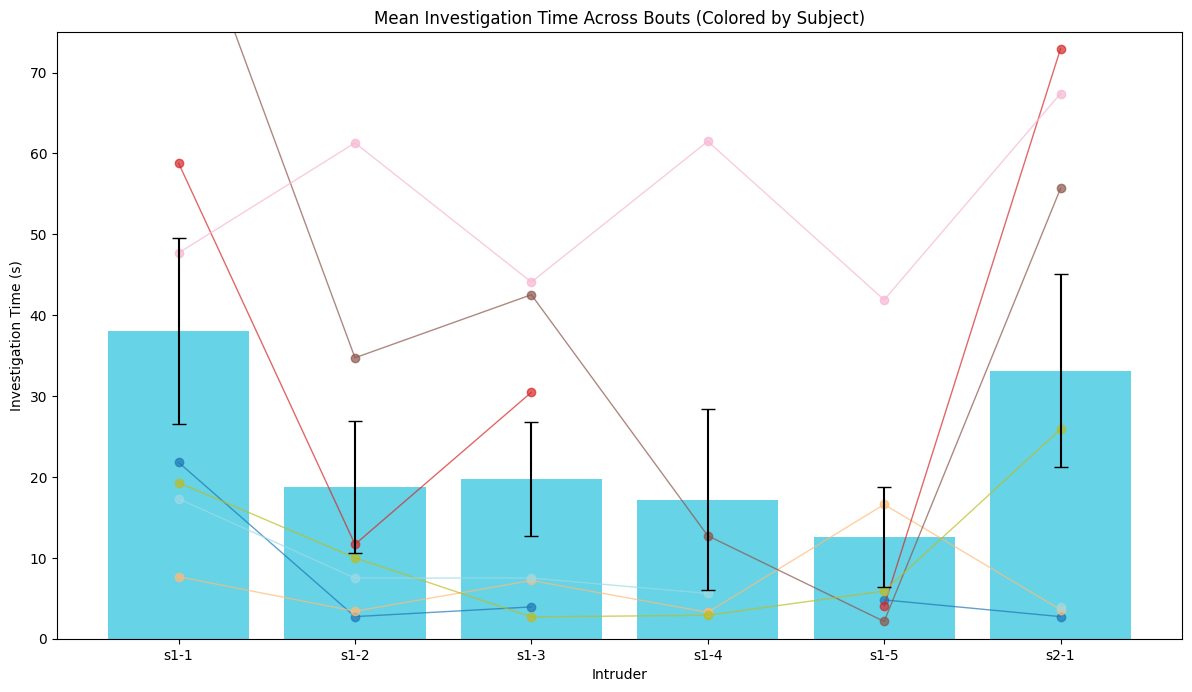

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').

    Parameters
    ----------
    df : pandas.DataFrame
        Rows = subjects, columns = bouts, values = metric to plot
    title : str
        Plot title
    ylabel : str
        Y-axis label
    custom_xtick_labels : list or None
        If provided, sets custom labels for the x-ticks
    custom_xtick_colors : list or None
        If provided, sets colors for the x-tick labels
    ylim : tuple or None
        (ymin, ymax) to fix the y-axis range
    bar_color : str
        Color for the mean bar chart
    yticks_increment : float or None
        If provided, sets a custom increment for y ticks
    xlabel : str
        X-axis label
    figsize : tuple
        Figure size
    pad_inches : float
        Padding around the figure
    cmap_name : str
        Name of a matplotlib colormap (e.g. 'tab10', 'tab20', 'viridis', etc.)

    Returns
    -------
    None (displays a plot)
    """

    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # Plot each subject's data in a unique color
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    plt.tight_layout(pad=pad_inches)
    plt.show()

def plot_behavior_metric_colored(df, 
                                 behavior="Investigation", 
                                 metric="investigation_time",
                                 title='Mean Across Bouts',
                                 ylabel='Mean Value',
                                 ylim=None,
                                 cmap_name='tab10'):
    """
    Same idea as plot_behavior_metric, but calls the color-coded spaghetti plot.
    """
    # 1) Filter by Behavior
    filtered_df = df[df["Behavior"] == behavior].copy()

    # 2) Group & compute the chosen metric
    if metric == "investigation_time":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
        plot_label = "Investigation Time (Sum)"
    elif metric == "average_bout_duration":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
        plot_label = "Average Bout Duration (Mean)"
    else:
        raise ValueError("metric must be either 'investigation_time' or 'average_bout_duration'")

    # 3) Pivot so that each row = Subject, each column = Bout, values = numeric
    pivot_df = grouped.pivot(index="Subject", columns="Bout", values="Duration (s)")

    # 4) Call your color-coded function on the pivoted, numeric DataFrame
    hab_dishab_plot_y_across_bouts_colored(
        df=pivot_df,
        title=title,
        ylabel=ylabel if ylabel else plot_label,
        ylim=ylim,
        cmap_name=cmap_name
    )


plot_behavior_metric_colored(
    df=filtered_summary_df,  # The full summary DataFrame
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_27530/4041033729.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


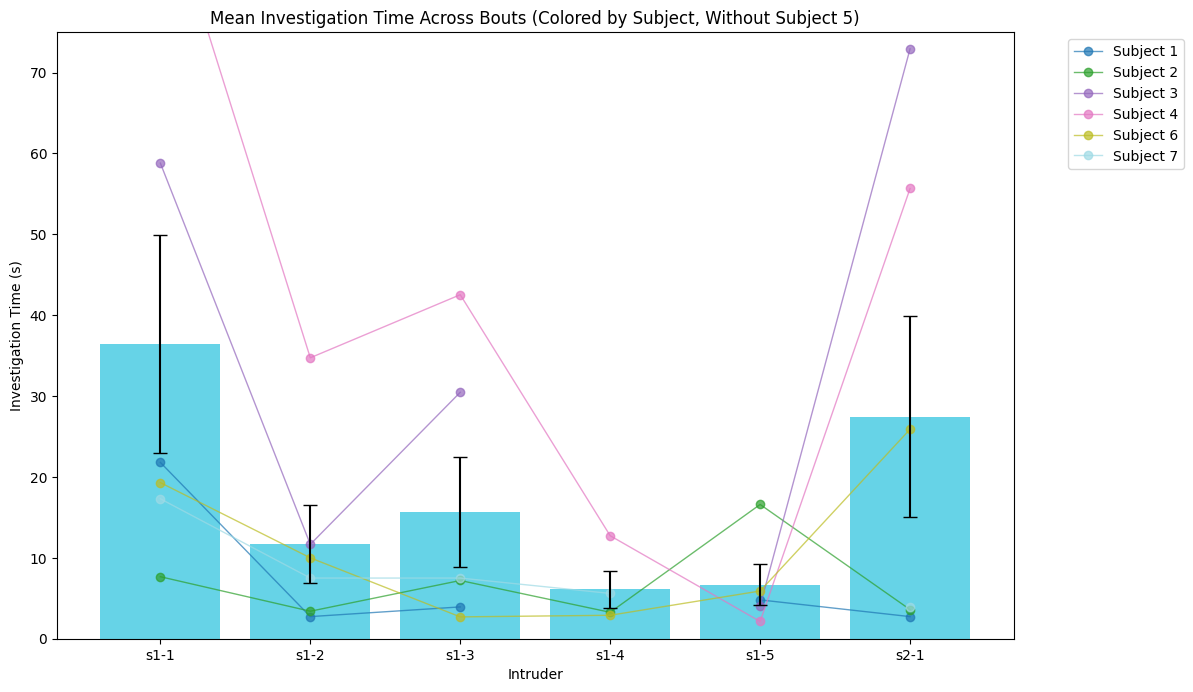

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()

# Filter out Subject 5 from the summary DataFrame before pivoting
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Re-run the analysis and plotting with the filtered data
plot_behavior_metric_colored(
    df=filtered_df,  # Now without Subject 5
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject, Without Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()


# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
    pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)


NameError: name 'pivot_df' is not defined